In [142]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.base.model
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
import ml_metrics as metrics       # эта метрика вообще нужна?
from itertools import product
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
#import xgboost as xgb


In [143]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
import bokeh
output_notebook()

Loading BokehJS ...

In [144]:
def get_table(file):
    df = pd.read_csv(file, ",", parse_dates=['Date'], dayfirst=True)
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.drop('index', 1)
    print( df.head())
    return df

In [145]:
def show_plot(df):
    s1 = figure(plot_width=850, plot_height=250,x_axis_type="datetime")
    s1.line(df.index, df['Value'], line_color='blue')
    
    plt.figure(figsize=(15, 4))
    layout = (1, 2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))

    smt.graphics.plot_acf(df['Value'], lags=30, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(df['Value'], lags=30, ax=pacf_ax, alpha=0.5)
    
    show(s1)

In [146]:
def decomposition(df, model):
    x = df.index
    r = statsmodels.tsa.seasonal.seasonal_decompose(df, model=model)
    
    s = figure(plot_width=850, plot_height=450,x_axis_type="datetime", x_axis_label='Time', y_axis_label='Value')
    s.line(x, r.seasonal['Value'], legend="Seasonal component", line_color='red')
    s.line(x, r.trend['Value'], legend="Trend", line_color='blue') 
    s.line(x, r.resid['Value'], legend="Lags", line_color='grey')
    s.legend.location = "top_left"
    
    show(s)
       
    return r.resid, r.trend, r.seasonal

In [147]:
def train_model(df, order):
    model = sm.tsa.ARIMA(df, order=order).fit()
    print(model.summary())
    return model

def prediction(model, test, trend, seasonal):
    pred = model.predict(start=348, end=407)
    pred += trend + seasonal
    r2 = r2_score(test, pred)
    print ('R^2: %1.2f' % r2)
    print(metrics.rmse(pred, test))
    test.plot()
    pred.plot(style='r--')

In [148]:
def stationarity_test(df):
    x = df.index
    rollmean = df.rolling(window=12).mean()
    ewma = df.ewm(halflife=12).mean()
    rolstd = df.rolling(window=12).std()

    p = figure(plot_width=850, plot_height=500,x_axis_type="datetime", x_axis_label='Time', y_axis_label='Value')

    p.line(x, df['Value'], legend="df", line_color='green')
    p.line(x, rollmean['Value'], legend="rollmean", line_color='blue') 
    p.line(x, ewma['Value'], legend="ewma", line_color='red')
    p.line(x, rolstd['Value'], legend="rolstd", line_color='orange')
    p.legend.location = "top_left"
    show(p)
    
    df = df.dropna()
    test = sm.tsa.adfuller(df['Value'])
    print ( 'adf: ', test[0])
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')
    

In [149]:
df = get_table('training.csv')
df2 = get_table('testing.csv')
df2.shape

              Value
Date               
1959-01-01  22.8331
1959-02-01  23.2802
1959-03-01  23.6156
1959-04-01  24.1186
1959-05-01  24.4820
              Value
Date               
1989-01-01  64.6158
1989-02-01  64.3268
1989-03-01  64.4548
1989-04-01  64.5270
1989-05-01  64.0662


(60, 1)

In [150]:
stationarity_test(df)

adf:  -0.253391179928
p-value:  0.931851042299
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
есть единичные корни, ряд не стационарен


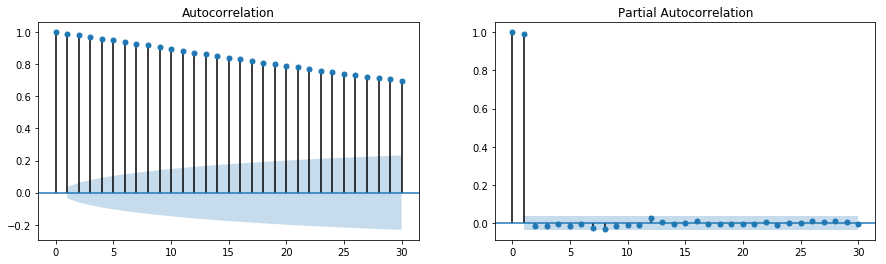

In [153]:
show_plot(df)

## Аддитивная модель

In [154]:
aresid, atrend, aseasonal = decomposition(df, 'additive')

## Мультипликативная модель

In [188]:
residual, trend, seasonal = decomposition(df, 'multiplicative')

Заметим, что в мультипликативной модели меньше разброс ошибок

In [112]:
df['Value'] = df['Value'].dropna()
test = sm.tsa.adfuller(df['Value'])
print ( 'adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -0.253391179928
p-value:  0.931851042299
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
есть единичные корни, ряд не стационарен


In [123]:
df1 = df.diff(periods=1).dropna()
df1.head()

,Value
Date,
1959-02-01,0.4471
1959-03-01,0.3354
1959-04-01,0.5030
1959-05-01,0.3634
1959-06-01,0.0279


In [189]:
stationarity_test(df1)

adf:  -7.36731149521
p-value:  9.1641495611e-11
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
единичных корней нет, ряд стационарен


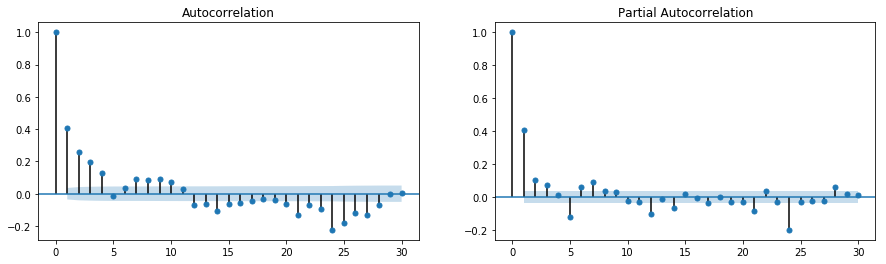

In [187]:
show_plot(df1) #интегрированный ряд первого порядка, его автокореляция и частичная автокорелляция

In [124]:
train, test = df.Value[0:-30], df.Value[329:]

### Эта херня не работает, r2_score лучше не становится

In [53]:
ps = range(0, 5)
qs = range(0, 4)
tr = range(0, 2)


parameters = product(ps, qs)
parameters_list = list(parameters)

predictions = list()
#results = []
best_aic = float("inf")


for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        #model = sm.tsa.SARIMAX(train, order=(param[0],1,param[1]), trend = [1,1,1,1]).fit()
        model=sm.tsa.ARIMA(train, order=(param[0], 1, param[1])).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        #results.append([param, model.aic])


100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


In [54]:
print(best_aic, best_param)

238.59805326613593 (3, 2)


In [158]:
model = sm.tsa.ARIMA(train, order=(3,1,2)).fit()
print(model.summary())

pred = model.predict(start=330, end=360, typ='levels')
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(pred, test))

p = figure(plot_width=600, plot_height=300,x_axis_type="datetime")

p.line(df.index, test, legend="test")
p.line(df.index, pred, legend="pred", color = 'red', line_dash="4 4")
show(p)
#test.plot()
#pred.plot(style='r--')

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  329
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -112.299
Method:                       css-mle   S.D. of innovations              0.340
Date:                Thu, 07 Dec 2017   AIC                            238.598
Time:                        14:26:54   BIC                            265.170
Sample:                    02-01-1959   HQIC                           249.199
                         - 06-01-1986                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1046      0.037      2.818      0.005       0.032       0.177
ar.L1.D.Value     0.4501      0.279      1.612      0.108      -0.097       0.997
ar.L2.D.Value    -0.6051      0.191     

C:\Anaconda3\lib\site-packages\bokeh\models\sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 360), ('y', 31)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
C:\Anaconda3\lib\site-packages\bokeh\models\sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 360), ('y', 31)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


In [159]:
model1 = sm.tsa.SARIMAX(df.Value, order=(1,1,1), trend=[1,1,1,0]).fit()

pred = model1.predict(start=330, end=360)
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(test,pred))

p = figure(plot_width=600, plot_height=300,x_axis_type="datetime")

p.line(df.index, test)
p.line(df.index, pred, color = 'red', line_dash="4 4")
show(p)

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


R^2: 0.99
0.200751482827


C:\Anaconda3\lib\site-packages\bokeh\models\sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 360), ('y', 31)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
C:\Anaconda3\lib\site-packages\bokeh\models\sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 360), ('y', 31)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


In [160]:
model1 = sm.tsa.SARIMAX(train, order=(1,1,1), trend=[1,1,1,1]).fit()
pred = model1.predict(start = 330, end=360)
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(test,pred))

p = figure(plot_width=600, plot_height=300,x_axis_type="datetime")

p.line(df.index, test)
p.line(df.index, pred, color = 'red', line_dash="4 4")
show(p)

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


R^2: 0.46
1.83823947022


C:\Anaconda3\lib\site-packages\bokeh\models\sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 360), ('y', 31)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
C:\Anaconda3\lib\site-packages\bokeh\models\sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 360), ('y', 31)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


In [265]:
model1.aic

245.65672560155119

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


R^2: -0.05
1.59652628504


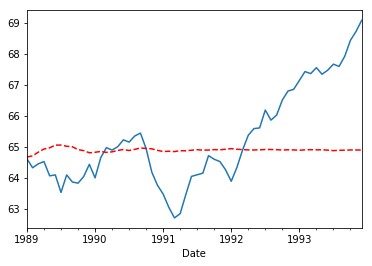

In [184]:
model1 = sm.tsa.SARIMAX(df.Value, order=(5, 1, 1), seasonal_order=(5, 0, 3, 6)).fit()
pred = model1.predict(start = 360, end=419, dynamic=True)
r2 = r2_score(df2['Value'], pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(df2['Value'],pred))

df2['Value'].plot()
pred.plot(style='r--')

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


R^2: 0.58
1.00555174686


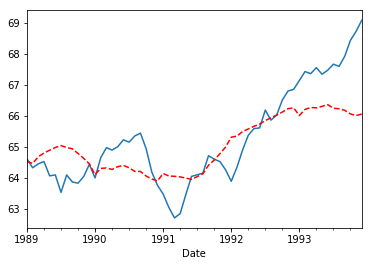

In [186]:
model1 = sm.tsa.SARIMAX(df.Value, order=(1, 1, 1), seasonal_order=(8, 0, 5, 12)).fit()
pred = model1.predict(start = 360, end=419, dynamic=True)
r2 = r2_score(df2['Value'], pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(df2['Value'],pred))

df2['Value'].plot()
pred.plot(style='r--')

In [162]:
p = figure(plot_width=600, plot_height=300,x_axis_type="datetime")

p.line(df.index, df.Value)
p.line(df2.index, pred, color = 'red', line_dash="4 4")
p.line(df2.index, df2.Value, color = 'orange')
show(p)

#df['Value'].plot()
#df2['Value'].plot()
#pred.plot(style='r--')

In [28]:
train, test = df1.Date[0:-30], df1[329:]

model1 = sm.tsa.SARIMAX(train, order=(1,1,1), trend='c').fit()
pred = model1.predict(start = 330, end=360, dynamic=True, typ='levels')
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(df2['Value'],pred))

df2['Value'].plot()
pred.plot(style='r--')

AttributeError: 'Series' object has no attribute 'Date'

In [ ]:
r = statsmodels.tsa.seasonal.seasonal_decompose(df, model='model') 